# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

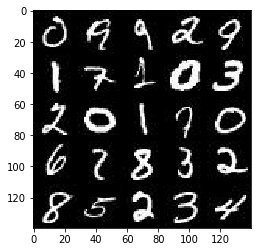

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

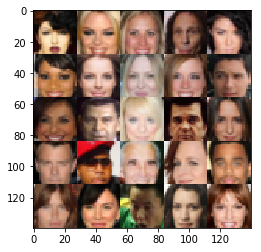

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,*(image_width,image_height,image_channels)),name='input_real')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,shape=())
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #14,14,64
        d1 = tf.layers.conv2d(images,64,kernel_size=5,strides=2,padding='same')
        d1 = tf.maximum(alpha * d1, d1)
        
        #7,7,128
        d2 = tf.layers.conv2d(d1,128,kernel_size=5,strides=2,padding='same')
        d2 = tf.layers.batch_normalization(d2,training=True)
        d2 = tf.maximum(alpha * d2, d2)
        #4,4,256
        d3 = tf.layers.conv2d(d2,256,kernel_size=5,strides=2,padding='same')
        d3 = tf.layers.batch_normalization(d3,training=True)
        d3 = tf.maximum(alpha * d3,d3)
        
        #2,2,512
        d4 = tf.layers.conv2d(d3,512,kernel_size=5,strides=2,padding='same')
        d4 = tf.layers.batch_normalization(d4,training=True)
        d4 = tf.maximum(alpha * d4, d4)
        
        d5 = tf.reshape(d4,(-1,2*2*512))
        
        logits = tf.layers.dense(d5,1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        g0 = tf.layers.dense(z,512 * 3 * 3)
        g0 = tf.reshape(g0,(-1,3,3,512))
        g1 = tf.layers.batch_normalization(g0,training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        #7,7,128
        g2 = tf.layers.conv2d_transpose(g1,128,3,strides=2,padding='valid')
        g2 = tf.layers.batch_normalization(g2,training=is_train)
        g2= tf.maximum(alpha * g2, g2)
        
        #14,14,64
        g3 = tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same')
        g3 = tf.layers.batch_normalization(x3,training=is_train)
        g3 = tf.maximum(alpha * g3, g3)
        
        #28,28,32
        g4 = tf.layers.conv2d_transpose(g3,32,5,strides=2,padding='same')
        g4 = tf.layers.batch_normalization(g4,training=is_train)
        g4 = tf.maximum(alpha * g4, g4)
        
        #28,28,out_channel_dim
        logits = tf.layers.conv2d_transpose(g4,out_channel_dim,5,strides=1,padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #Generator生成图片
    g_model_out = generator(input_z,out_channel_dim,is_train=True)
    #real picture from discriminator
    d_real_out,d_real_logits = discriminator(input_real,reuse=False)
    #fake picture from discriminator
    d_fake_out,d_fake_logits = discriminator(g_model_out,reuse=True)
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_out)))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,
                                                                         labels=tf.ones_like(d_real_out)*0.9))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_out)))
    # Discriminator loss (fake + real)
    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimizers
    # If we don't include the update ops as dependencies on the train step, the 
    # tf.layers.batch_normalization layers won't update their population statistics,
    # which will cause the model to fail at inference time
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        #训练Discriminator和Generator优化器
        d_loss_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_loss_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_loss_opt, g_loss_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples,real_img_w,real_img_h,num_channels = data_shape
    #模型输入占位函数
    real_input, z_input, lr = model_inputs(real_img_w,real_img_h,num_channels,z_dim)
    #计算损失
    d_loss,g_loss = model_loss(real_input,z_input,num_channels)
    #optimizers
    d_train_opt,g_train_opt = model_opt(d_loss,g_loss,lr,beta1)
    
    
    
    #每 100 批次输出一次 generator 的输出
    every_batches = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            g_loss_sum = 0
            d_loss_sum = 0
            batch_count = 0
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_count += 1
                batch_images * 2
                #随机向量batch_z
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                #run optimizers
                _ = sess.run(d_train_opt,feed_dict={lr:learning_rate,
                                                real_input:batch_images,
                                                z_input:batch_z})
                _ = sess.run(g_train_opt,feed_dict={lr:learning_rate,
                                               z_input:batch_z})
                #累积loss
                d_loss_sum += d_loss.eval({z_input:batch_z,
                                          real_input:batch_images})
                g_loss_sum += g_loss.eval({z_input:batch_z})
                
                if steps % every_batches == 0:
                    show_generator_output(sess=sess,n_images=16,out_channel_dim=num_channels,
                                          input_z=z_input,image_mode=data_image_mode)
                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                         "Avg. Discriminator Loss: {:.4f}...".format(d_loss_sum / batch_count),
                          "Avg. Generator Loss: {:.4f}".format(g_loss_sum / batch_count))
                    d_loss_sum = 0
                    g_loss_sum = 0
                    batch_count = 0
        print("Training finshed!")

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

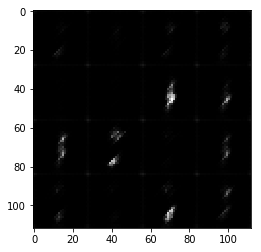

Epoch 1/2... Avg. Discriminator Loss: 1.4712... Avg. Generator Loss: 2.2878


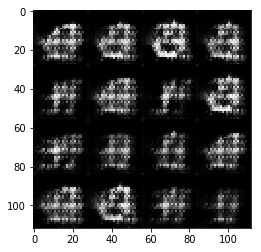

Epoch 1/2... Avg. Discriminator Loss: 0.9622... Avg. Generator Loss: 2.6033


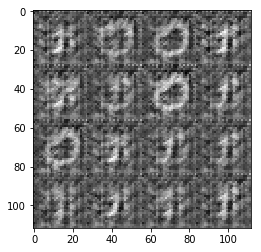

Epoch 1/2... Avg. Discriminator Loss: 0.7261... Avg. Generator Loss: 3.3126


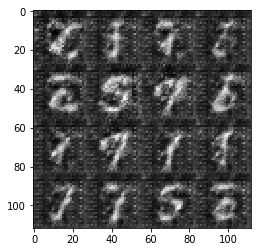

Epoch 1/2... Avg. Discriminator Loss: 0.8805... Avg. Generator Loss: 2.2570


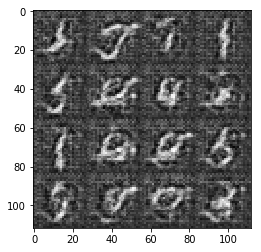

Epoch 1/2... Avg. Discriminator Loss: 0.8780... Avg. Generator Loss: 2.0108


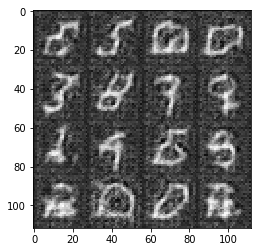

Epoch 1/2... Avg. Discriminator Loss: 0.9019... Avg. Generator Loss: 2.2650


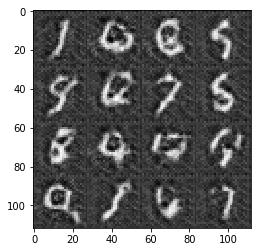

Epoch 1/2... Avg. Discriminator Loss: 0.8026... Avg. Generator Loss: 2.0383


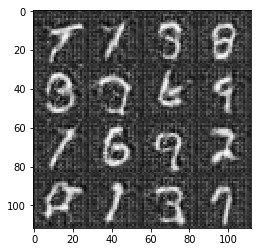

Epoch 1/2... Avg. Discriminator Loss: 0.8014... Avg. Generator Loss: 2.3960


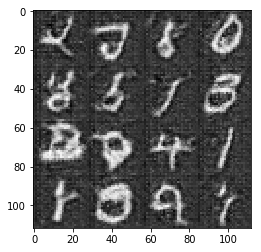

Epoch 1/2... Avg. Discriminator Loss: 0.9960... Avg. Generator Loss: 1.7703


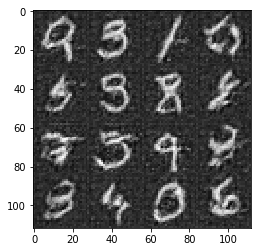

Epoch 2/2... Avg. Discriminator Loss: 0.8972... Avg. Generator Loss: 1.8945


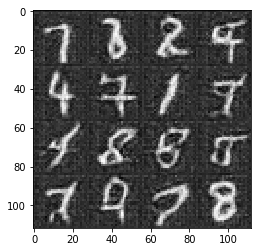

Epoch 2/2... Avg. Discriminator Loss: 0.9834... Avg. Generator Loss: 1.7482


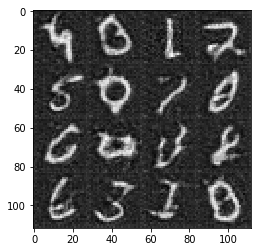

Epoch 2/2... Avg. Discriminator Loss: 0.8795... Avg. Generator Loss: 2.2213


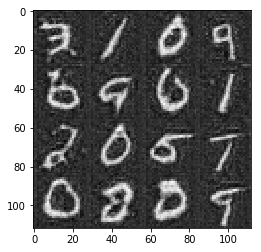

Epoch 2/2... Avg. Discriminator Loss: 0.8058... Avg. Generator Loss: 2.0603


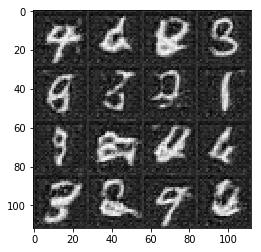

Epoch 2/2... Avg. Discriminator Loss: 0.8006... Avg. Generator Loss: 2.2309


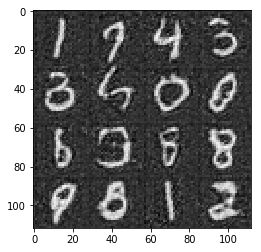

Epoch 2/2... Avg. Discriminator Loss: 0.9574... Avg. Generator Loss: 1.6282


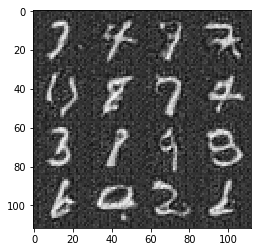

Epoch 2/2... Avg. Discriminator Loss: 0.8902... Avg. Generator Loss: 2.1727


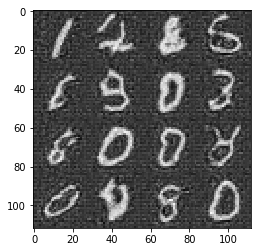

Epoch 2/2... Avg. Discriminator Loss: 0.8604... Avg. Generator Loss: 1.6952


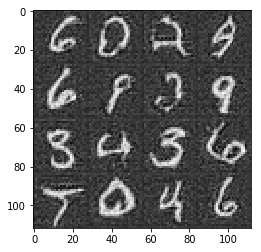

Epoch 2/2... Avg. Discriminator Loss: 0.8586... Avg. Generator Loss: 2.0225


In [79]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

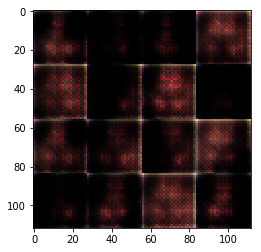

Epoch 1/1... Avg. Discriminator Loss: 1.0870... Avg. Generator Loss: 3.4020


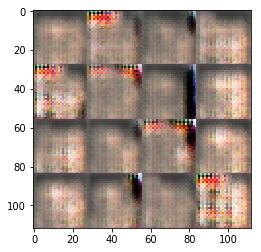

Epoch 1/1... Avg. Discriminator Loss: 0.8315... Avg. Generator Loss: 2.5294


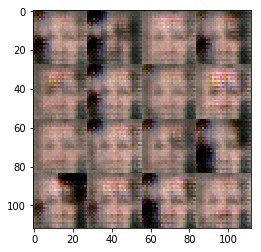

Epoch 1/1... Avg. Discriminator Loss: 0.8629... Avg. Generator Loss: 2.2872


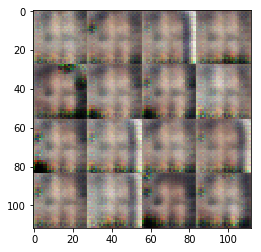

Epoch 1/1... Avg. Discriminator Loss: 0.8815... Avg. Generator Loss: 2.0289


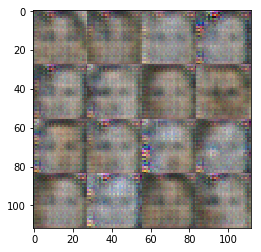

Epoch 1/1... Avg. Discriminator Loss: 1.1330... Avg. Generator Loss: 1.8193


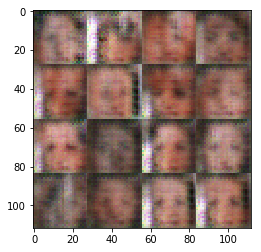

Epoch 1/1... Avg. Discriminator Loss: 1.1153... Avg. Generator Loss: 1.3942


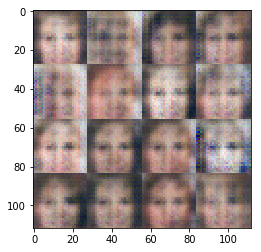

Epoch 1/1... Avg. Discriminator Loss: 1.0908... Avg. Generator Loss: 1.5644


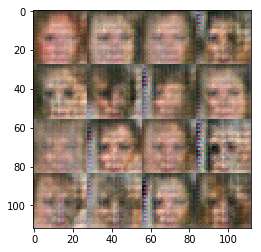

Epoch 1/1... Avg. Discriminator Loss: 1.0459... Avg. Generator Loss: 1.5850


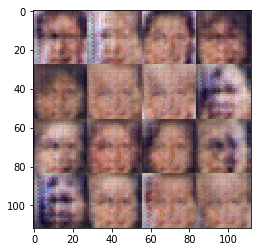

Epoch 1/1... Avg. Discriminator Loss: 1.1323... Avg. Generator Loss: 1.4451


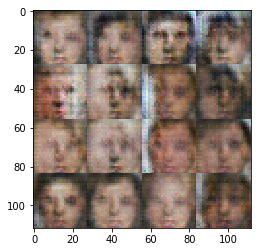

Epoch 1/1... Avg. Discriminator Loss: 1.0869... Avg. Generator Loss: 1.5580


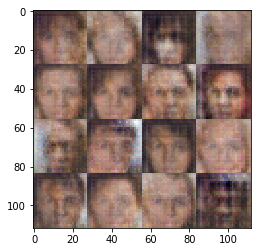

Epoch 1/1... Avg. Discriminator Loss: 1.0824... Avg. Generator Loss: 1.5977


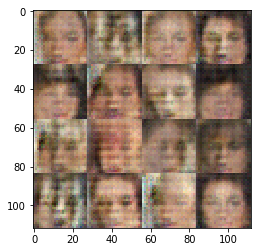

Epoch 1/1... Avg. Discriminator Loss: 1.0859... Avg. Generator Loss: 1.4936


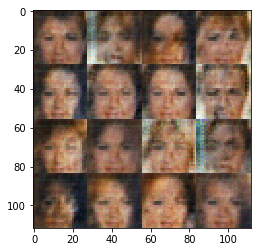

Epoch 1/1... Avg. Discriminator Loss: 1.0703... Avg. Generator Loss: 1.6215


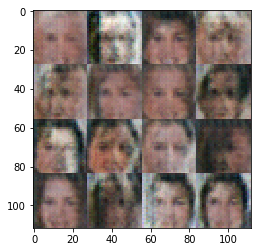

Epoch 1/1... Avg. Discriminator Loss: 1.0257... Avg. Generator Loss: 1.6354


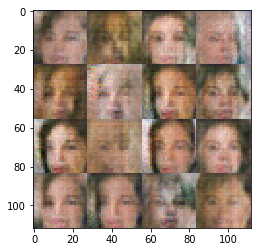

Epoch 1/1... Avg. Discriminator Loss: 1.0576... Avg. Generator Loss: 1.7103


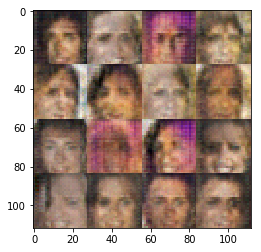

Epoch 1/1... Avg. Discriminator Loss: 1.0737... Avg. Generator Loss: 1.6628


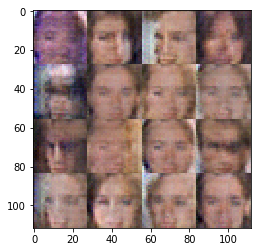

Epoch 1/1... Avg. Discriminator Loss: 1.1256... Avg. Generator Loss: 1.4314


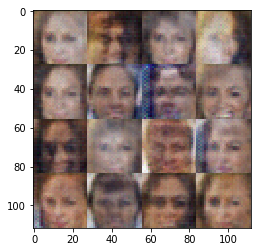

Epoch 1/1... Avg. Discriminator Loss: 1.1229... Avg. Generator Loss: 1.3964


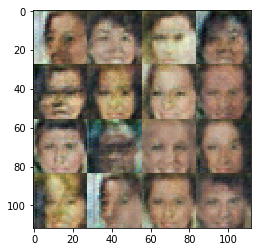

Epoch 1/1... Avg. Discriminator Loss: 1.1195... Avg. Generator Loss: 1.3960


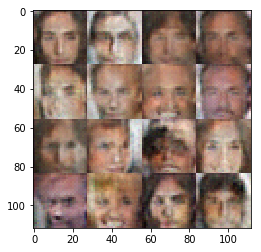

Epoch 1/1... Avg. Discriminator Loss: 1.0956... Avg. Generator Loss: 1.4327


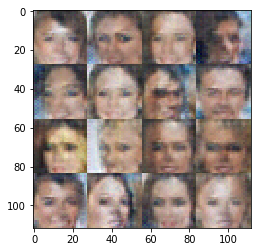

Epoch 1/1... Avg. Discriminator Loss: 1.1582... Avg. Generator Loss: 1.2895


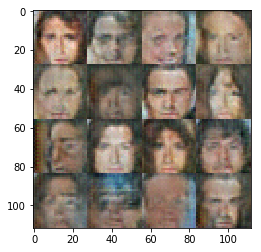

Epoch 1/1... Avg. Discriminator Loss: 1.1221... Avg. Generator Loss: 1.2996


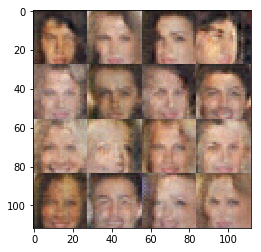

Epoch 1/1... Avg. Discriminator Loss: 1.1913... Avg. Generator Loss: 1.2457


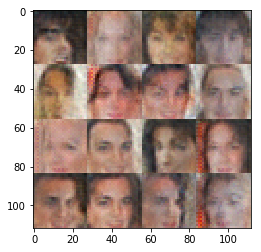

Epoch 1/1... Avg. Discriminator Loss: 1.1862... Avg. Generator Loss: 1.2483


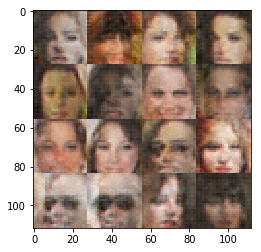

Epoch 1/1... Avg. Discriminator Loss: 1.2266... Avg. Generator Loss: 1.1768


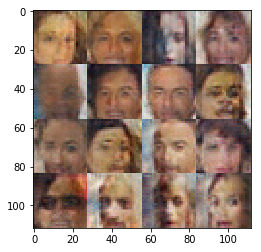

Epoch 1/1... Avg. Discriminator Loss: 1.1605... Avg. Generator Loss: 1.2025


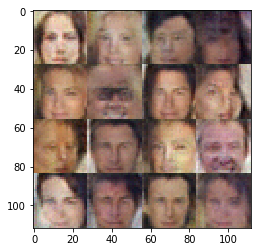

Epoch 1/1... Avg. Discriminator Loss: 1.2441... Avg. Generator Loss: 1.1432


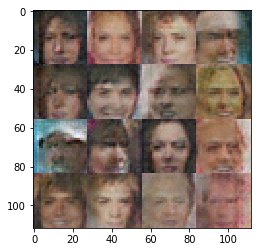

Epoch 1/1... Avg. Discriminator Loss: 1.2163... Avg. Generator Loss: 1.0731


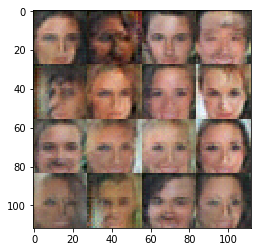

Epoch 1/1... Avg. Discriminator Loss: 1.2340... Avg. Generator Loss: 1.1199


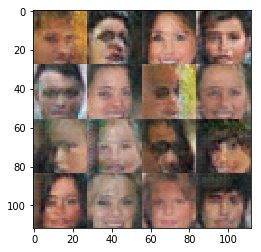

Epoch 1/1... Avg. Discriminator Loss: 1.2410... Avg. Generator Loss: 1.1014


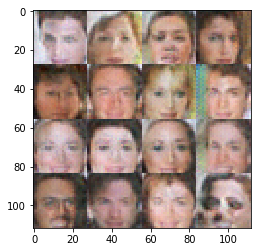

Epoch 1/1... Avg. Discriminator Loss: 1.2384... Avg. Generator Loss: 1.1234
MNIST training finshed!


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。